In [22]:
from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv
from typing import Annotated, TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_qdrant import Qdrant
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage
from langchain.chains import RetrievalQA
from qdrant_client import QdrantClient
from pydantic import BaseModel,Field
from IPython.display import Image,display
from typing_extensions import Literal
import os

In [23]:
# Load environment variables from .env (ensure OPENAI_API_KEY is set)
load_dotenv()

# Connect to Qdrant
client = QdrantClient(url="http://localhost:6333")

# Initialize OpenAI Embeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

# Setup vector store
vector_store = Qdrant(
    client=client,
    collection_name="hugging_cat",
    embeddings=embedding_model
)

# Retriever + OpenAI LLM
retriever = vector_store.as_retriever()
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

# RetrievalQA chain
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

# State definition
class State(TypedDict):
    messages: Annotated[list, add_messages]
    decision:str

class CatRelated(BaseModel):
    step:Literal["yes","no"]=Field(description="CKD related or not")


# Chatbot node logic
def chatbot(state: State) -> State:
    last_human_msg = [m for m in state["messages"] if isinstance(m, HumanMessage)][-1]
    query = last_human_msg.content

    response = qa_chain.invoke({"query": query})
    response_text = response["result"]

    return {"messages": state["messages"] + [AIMessage(content=response_text)]}

router=llm.with_structured_output(CatRelated)

def llm_call_router(state:State):
    """ Route the input to the appropriate node"""
    decision=router.invoke([
        SystemMessage(
            content="""You are a strict classifier. Return 'yes' if the following query is related to cats,cat health, feline chronic kidney disease (CKD), cat nutrition, or general feline care. Otherwise, return 'no'. Respond with only 'yes' or 'no'."""
        ),
        HumanMessage(content=state["messages"][-1].content)
    ])

    return {"decision":decision.step}

def route_decision(state:State):

    if state["decision"]=="yes":
        return "chatbot"
    elif state["decision"]=="no":
        return "end"

/opt/anaconda3/envs/py312/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1772: UserWarning: Cannot use method='json_schema' with model gpt-4-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


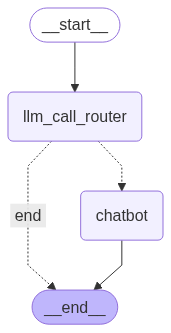

Chronic kidney disease (CKD) is a condition characterized by a gradual loss of kidney function over time. It can progress to kidney failure if not managed properly. The symptoms of CKD are often not specific, meaning they can also be caused by other illnesses. Because the kidneys are highly adaptable and able to compensate for lost function, symptoms may not appear until irreversible damage has occurred. Common symptoms of CKD include:

1. **Fatigue and weakness** - Due to anemia or accumulation of waste products in the body.
2. **Changes in urination** - This could be urinating more or less frequently, or noticing that the urine is foamy or bloody.
3. **Swelling (edema)** - Fluid retention can cause swelling in the legs, ankles, feet, face, or hands.
4. **Shortness of breath** - Fluid buildup in the lungs can make it difficult to breathe.
5. **Sleep problems** - Trouble sleeping due to muscle cramps or restless legs.
6. **Nausea and vomiting** - Buildup of waste products in the bloods

In [24]:

# Build the LangGraph
graph = StateGraph(State)

graph.add_node("llm_call_router", llm_call_router)
graph.add_node("chatbot", chatbot)

graph.add_edge(START,"llm_call_router")
graph.add_conditional_edges("llm_call_router",route_decision,{
    "chatbot":"chatbot",
    "end":END
})

graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

result = graph_builder.invoke({
        "messages": [HumanMessage(content="What are the symptoms of CKD?")]
    })
print(result["messages"][-1].content)
